## Numerai Signals Example Predictions



The goal of this notebook is to:
>1. read some data from a free source (Yahoo Finance Wrapper: yfinance)
2. create features within each era (RSI quintiles and lags)
3. train a simple tree model on those features against the Numerai Signals targets (normalized and neutralized rankings per era)
4. submit the model's predictions to Signals using numerapi

## 1. Setup

### Install and import dependencies

In [ ]:
!pip install numerapi==2.3.8
#!pip install yfinance
!pip install git+https://github.com/leonhma/yfinance.git #drop-in replacement yfinance fork for failed downloads, h/t ceunen
!pip install simplejson

  Cloning https://github.com/leonhma/yfinance.git to /tmp/pip-req-build-aj4f7692
  Running command git clone -q https://github.com/leonhma/yfinance.git /tmp/pip-req-build-aj4f7692
     |████████████████████████████████| 5.5MB 6.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22745 sha256=6c150909744c8bb3cd36c1e362670434dd4fcbd1b05311bcc4c030dbe9f4e7df
  Stored in directory: /tmp/pip-ephem-wheel-cache-8z37yf_g/wheels/b7/91/5b/b1c9f9c937e88ef6b5e7bb8e5172a841230123d6173eb03045
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 133kB 6.4MB/s 


In [ ]:
import numerapi
import yfinance
import simplejson

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests as re
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

### Numerapi and Signals tickers
Find your Numerapi public and private keys from https://numer.ai/account

In [ ]:
napi = numerapi.SignalsAPI()

In [ ]:
# read in list of active Signals tickers which can change slightly era to era
eligible_tickers = pd.Series(napi.ticker_universe(), name='ticker') 
print(f"Number of eligible tickers: {len(eligible_tickers)}")

Number of eligible tickers: 5368


In [ ]:
# read in yahoo to numerai ticker map, still a work in progress, h/t wsouza and 
# this tickermap is a work in progress and not guaranteed to be 100% correct
ticker_map = pd.read_csv('https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv')
ticker_map = ticker_map[ticker_map.bloomberg_ticker.isin(eligible_tickers)]

numerai_tickers = ticker_map['bloomberg_ticker']
yfinance_tickers = ticker_map['yahoo']
print(f"Number of eligible tickers in map: {len(ticker_map)}")

Number of eligible tickers in map: 4473


### YFinance price feed download
Download price data (adjusted close) using Yahoo Finance wrapper: https://github.com/ranaroussi/yfinance and https://pypi.org/project/yfinance/. In this case, we're using a fork of yfinance to handle download errors. You should be able to download data for anywhere between 2,000 - 4,000 Signals tickers. Depending on your connection, downloading all of the tickers may take >15 minutes.

#### Option #1 (single download)

In [ ]:
raw_data = yfinance.download(yfinance_tickers.str.cat(sep=' '), start='2002-12-01', threads=True) 
raw_data.head()
full_data = raw_data['Adj Close'].stack().reset_index()

#### Option #2 (chunk downloads if Option #1 fails)
Since yfinance will sometimes hang/break with JSON Decode Errors, by chunking our downloads we can usually get more tickers. The library isn't perfect, so sometimes even valid tickers will fail.

If Option #1 doesn't work, uncomment all cells below and try to re-download the data

In [ ]:
# n = 600  #chunk row size
# chunk_df = [yfinance_tickers.iloc[i:i+n] for i in range(0, len(yfinance_tickers), n)]

In [ ]:
# concat_dfs = []
# for df in chunk_df:
#     try:
#         # set threads = True for faster performance, but tickers will fail, scipt may hang
#         # set threads = False for slower performance, but more tickers will succeed
#         temp_df = yfinance.download(df.str.cat(sep=' '), start='2002-12-01', threads=False)
#         temp_df = temp_df['Adj Close'].stack().reset_index()
#         concat_dfs.append(temp_df)
#     except simplejson.errors.JSONDecodeError:
#         pass

In [ ]:
# full_data = pd.concat(concat_dfs)

## 2. Data wrangle

In [ ]:
# properly position and clean raw data, after taking adjusted close only
full_data.columns = ['date', 'ticker', 'price']
full_data.set_index('date', inplace=True)

# convert yahoo finance tickers back to numerai tickers
full_data['ticker'] = full_data.ticker.map(dict(zip(yfinance_tickers, numerai_tickers)))

print(f"Number of tickers with data: {len(full_data.ticker.unique())}")
full_data.head()

Number of tickers with data: 4430


,ticker,price
date,,
2002-12-02,000060 KS,614.203308
2002-12-02,000080 KS,2155.658203
2002-12-02,000100 KS,5703.425781
2002-12-02,000120 KS,9900.000000
2002-12-02,000150 KS,8140.247070


### Engineer features
Now that we've downloaded the raw price data, we need to set up features we want to use to predict the target. For this example, we'll use RSI, which is a technical indicator that attempts to measure how "oversold" or "overbought" a stock is. A good rule of thumb is that an RSI > 70 indicates a stock is overbought and an RSI < 30 indicates a stock is oversold.

In [ ]:
def RSI(prices, interval=14):
  '''Computes Relative Strength Index given a price series and lookback interval
  Modified from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
  See more here https://www.investopedia.com/terms/r/rsi.asp'''
  delta = prices.diff()

  dUp, dDown = delta.copy(), delta.copy()
  dUp[dUp < 0] = 0
  dDown[dDown > 0] = 0

  RolUp = dUp.rolling(interval).mean()
  RolDown = dDown.rolling(interval).mean().abs()

  RS = RolUp / RolDown
  RSI = 100.0 - (100.0 / (1.0 + RS))
  return RSI

In [ ]:
ticker_groups = full_data.groupby('ticker')
full_data['RSI'] = ticker_groups['price'].transform(lambda x: RSI(x))

In [ ]:
# group by era (date) and create quintile labels within each era, useful for learning relative ranking
date_groups = full_data.groupby(full_data.index)
full_data['RSI_quintile'] = date_groups['RSI'].transform(lambda group: pd.qcut(group, 5, labels=False, duplicates='drop'))
full_data.dropna(inplace=True)

full_data.head()

,ticker,price,RSI,RSI_quintile
date,,,,
2002-12-20,000060 KS,567.426331,31.746109,1.0
2002-12-20,000100 KS,5885.677734,70.731707,4.0
2002-12-20,000120 KS,9640.000000,44.841270,2.0
2002-12-20,000150 KS,7505.939453,28.571198,1.0
2002-12-20,000210 KS,9013.365234,49.315025,3.0


In [ ]:
full_df = full_data

In [ ]:
full_df

,ticker,price,RSI,RSI_quintile
date,,,,
2002-12-20,000060 KS,567.426331,31.746109,1.0
2002-12-20,000100 KS,5885.677734,70.731707,4.0
2002-12-20,000120 KS,9640.000000,44.841270,2.0
2002-12-20,000150 KS,7505.939453,28.571198,1.0
2002-12-20,000210 KS,9013.365234,49.315025,3.0
...,...,...,...,...
2021-02-26,ZTS US,155.550003,42.372196,1.0
2021-02-26,ZUMZ US,45.270000,46.428573,2.0
2021-02-26,ZUO US,15.000000,39.603966,1.0


In [ ]:
ticker_groups = full_data.groupby('ticker')

#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc
num_days = 5
for day in range(num_days+1):
    full_data[f'RSI_quintile_lag_{day}'] = ticker_groups['RSI_quintile'].transform(lambda group: group.shift(day))

In [ ]:
full_data.tail()

,ticker,price,RSI,RSI_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5
date,,,,,,,,,,
2021-02-26,ZTS US,155.550003,42.372196,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2021-02-26,ZUMZ US,45.270000,46.428573,2.0,2.0,2.0,3.0,3.0,3.0,2.0
2021-02-26,ZUO US,15.000000,39.603966,1.0,1.0,2.0,3.0,3.0,4.0,3.0
2021-02-26,ZURN SW,371.500000,47.368406,2.0,2.0,3.0,2.0,1.0,2.0,2.0
2021-02-26,ZYXI US,14.600000,29.704803,0.0,0.0,1.0,1.0,1.0,2.0,1.0


In [ ]:
# create difference of the lagged features (change in RSI quintile by day)
for day in range(num_days):
    full_data[f'RSI_diff_{day}'] = full_data[f'RSI_quintile_lag_{day}'] - full_data[f'RSI_quintile_lag_{day + 1}']
    full_data[f'RSI_abs_diff_{day}'] = np.abs(full_data[f'RSI_quintile_lag_{day}'] - full_data[f'RSI_quintile_lag_{day + 1}'])

In [ ]:
full_data.tail()

,ticker,price,RSI,RSI_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,
2020-10-12,MNKD US,168.720001,64.311255,2.0,2.0,2.0,2.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1.0,-1.0,1.0
2020-10-12,TXT US,31.469999,72.376548,3.0,3.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2020-10-12,SAF FP,10.980000,65.399234,2.0,2.0,2.0,3.0,3.0,3.0,3.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-12,CAST SS,322.200012,41.706164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-12,TDG US,15.160000,41.411559,0.0,0.0,3.0,3.0,4.0,4.0,4.0,-3.0,3.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
feature_names = [f'RSI_quintile_lag_{num}' for num in range(num_days)] + [f'RSI_diff_{num}' for num in range(num_days)] + [f'RSI_abs_diff_{num}' for num in range(num_days)]
print(f'Features for training:\n {feature_names}')

Features for training:
 ['RSI_quintile_lag_0', 'RSI_quintile_lag_1', 'RSI_quintile_lag_2', 'RSI_quintile_lag_3', 'RSI_quintile_lag_4', 'RSI_diff_0', 'RSI_diff_1', 'RSI_diff_2', 'RSI_diff_3', 'RSI_diff_4', 'RSI_abs_diff_0', 'RSI_abs_diff_1', 'RSI_abs_diff_2', 'RSI_abs_diff_3', 'RSI_abs_diff_4']


### Numerai targets
Every era will begin on a Friday, ignore first two days of return (i.e. Mon, Tues) and then be based on the subsequent 4 days of return (i.e. Tuesday Close to Monday Close). The targets take on values of {0, 0.25, 0.5, 0.75, 1}, but they are not balanced classes. 

Try to think of the targets as normalized and neutralized rankings of returns within each era. 10% of the values take on 0 or 1. 40% of the values take on 0.25 or 0.75. And 50% of the values take on 0.5.

In [ ]:
TARGET_NAME = 'target'

In [ ]:
# read in Signals targets
numerai_targets = 'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val.csv'
targets = pd.read_csv(numerai_targets)
targets['date'] = pd.to_datetime(targets['friday_date'], format='%Y%m%d')

In [ ]:
targets.head()

,ticker,friday_date,data_type,target,date
0,000270 KS,20030131,train,0.50,2003-01-31
1,000810 KS,20030131,train,0.50,2003-01-31
2,000830 KS,20030131,train,0.50,2003-01-31
3,002790 KS,20030131,train,0.25,2003-01-31
4,003450 KS,20030131,train,0.25,2003-01-31


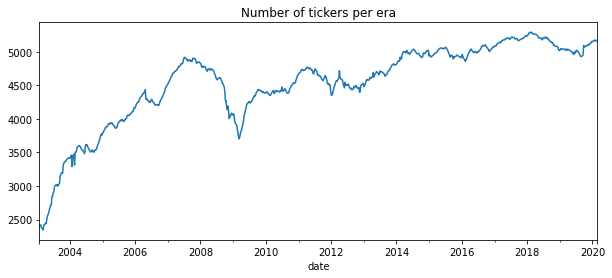

In [ ]:
# the number of tickers per era has generally increased
targets.groupby('date').apply(lambda x: len(x)).plot(kind='line', figsize=(10,4), title='Number of tickers per era')

In [ ]:
# the target classes are imbalanced, but we can treat this like a regression problem
targets.target.value_counts()

0.50    2024820
0.25     807654
0.75     807475
1.00     201771
0.00     201715
Name: target, dtype: int64

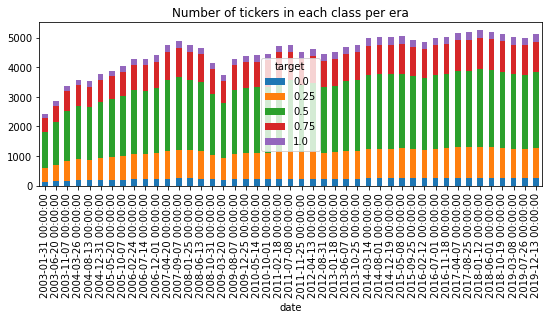

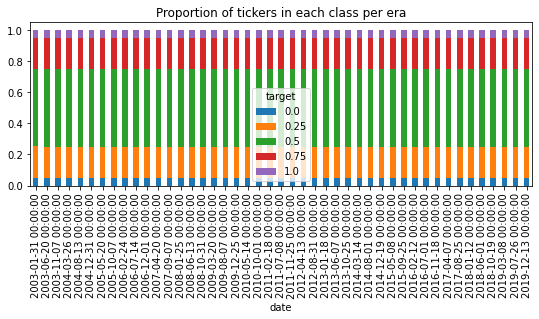

In [ ]:
# the imbalance is consistent across eras with a constant class ratio of: 5%, 20%, 50%, 20%, 5%
pivot_target = targets.groupby(['date','target']).apply(lambda x: len(x)).reset_index(1).pivot(columns='target',values=0)
pivot_target.iloc[::20].plot(kind='bar', stacked=True, figsize=(9,3), title='Number of tickers in each class per era')

stacked_data = pivot_target.apply(lambda x: x/sum(x), axis=1)
stacked_data.iloc[::20].plot(kind='bar', stacked=True, figsize=(9,3), title='Proportion of tickers in each class per era')

In [ ]:
targets.head()

,ticker,friday_date,data_type,target,date
0,000270 KS,20030131,train,0.50,2003-01-31
1,000810 KS,20030131,train,0.50,2003-01-31
2,000830 KS,20030131,train,0.50,2003-01-31
3,002790 KS,20030131,train,0.25,2003-01-31
4,003450 KS,20030131,train,0.25,2003-01-31


### Combine features and targets

In [ ]:
# merge our feature data with Numerai targets
ML_data = pd.merge(full_data.reset_index(), targets, on=['date','ticker']).set_index('date')
# print(f'Number of eras in data: {len(ML_data.index.unique())}')

# for training and testing we want clean, complete data only
ML_data.dropna(inplace=True)
ML_data = ML_data[ML_data.index.weekday==4] # ensure we have only fridays
ML_data = ML_data[ML_data.index.value_counts() > 200] # drop eras with under 200 observations per era

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
print(f'Number of eras in data: {len(ML_data.index.unique())}')

Number of eras in data: 851


In [ ]:
ML_data.head()

,ticker,price,RSI,RSI_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,friday_date,data_type,target
date,,,,,,,,,,,,,,,,,,,,,,,
2003-05-23,2388 HK,711.079712,64.317176,3.0,3.0,3.0,4.0,4.0,2.0,3.0,0.0,0.0,-1.0,1.0,0.0,0.0,2.0,2.0,-1.0,1.0,20030523,train,0.00
2003-05-23,16 HK,6.378429,48.309224,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20030523,train,0.50
2003-05-23,6 HK,7.475632,83.334838,4.0,4.0,4.0,4.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,20030523,train,0.50
2003-05-23,ECM LN,278.533203,56.435627,2.0,2.0,2.0,1.0,2.0,3.0,3.0,0.0,0.0,1.0,1.0,-1.0,1.0,-1.0,1.0,0.0,0.0,20030523,train,0.75
2003-05-23,ERG IM,205.304077,67.346930,3.0,3.0,4.0,4.0,4.0,4.0,4.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20030523,train,1.00


## 3. Model

### Train test split

In [ ]:
train_data = ML_data[ML_data['data_type'] == 'train']
test_data = ML_data[ML_data['data_type'] == 'validation']

### Train ML model on training data
Rather than creating rules like "assign 2 points if RSI < 30," let's just give these features derived from technical indicators to a machine learning model and see what rules the model comes up with given the targets.

In [ ]:
model = GradientBoostingRegressor()
model.fit(train_data[feature_names], train_data['target'])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

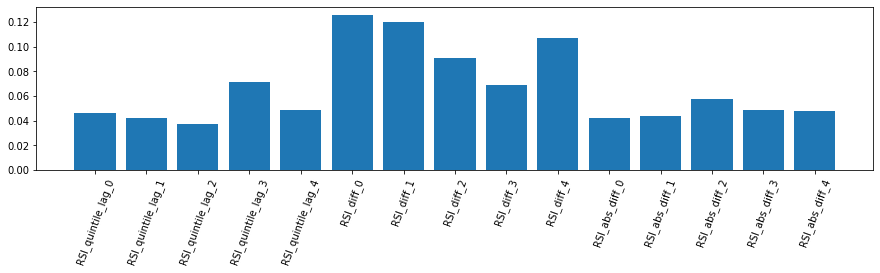

In [ ]:
plt.figure(figsize=(15,3))
plt.bar(feature_names, model.feature_importances_)
plt.xticks(rotation=70)
plt.show()

## 4. Predict and score model on validation data

### Predict validation data

In [ ]:
PREDICTION_NAME = 'prediction'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


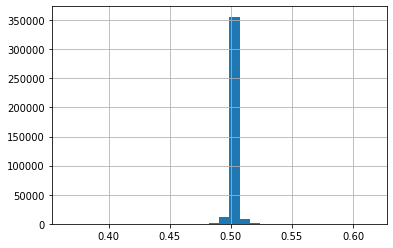

In [ ]:
train_data[PREDICTION_NAME] = model.predict(train_data[feature_names])
test_data[PREDICTION_NAME] = model.predict(test_data[feature_names])

#show prediction distribution, most should around the center
test_data[PREDICTION_NAME].hist(bins=30)

### Evaluate validation data predictions
We care about the relative rankings of our predictions relative to the targets, so use spearm correlation within each era

In [ ]:
def score(df):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print('\n')
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print('\n')
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

In [ ]:
# spearman scores by era
train_era_scores = train_data.groupby(train_data.index).apply(score)
test_era_scores = test_data.groupby(test_data.index).apply(score)

Mean Correlation: 0.0241
Median Correlation: 0.0238
Standard Deviation: 0.0504


Mean Pseudo-Sharpe: 0.4784
Median Pseudo-Sharpe: 0.4723


Hit Rate (% positive eras): 68.25%


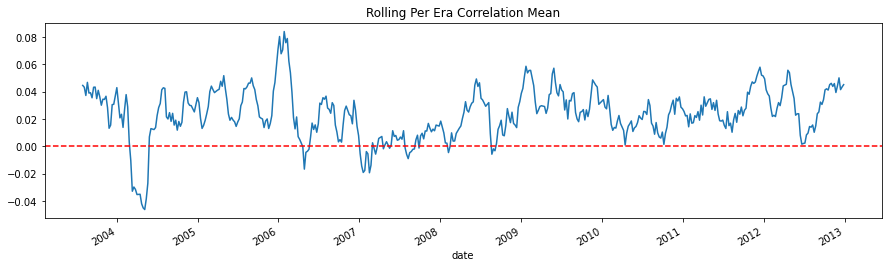

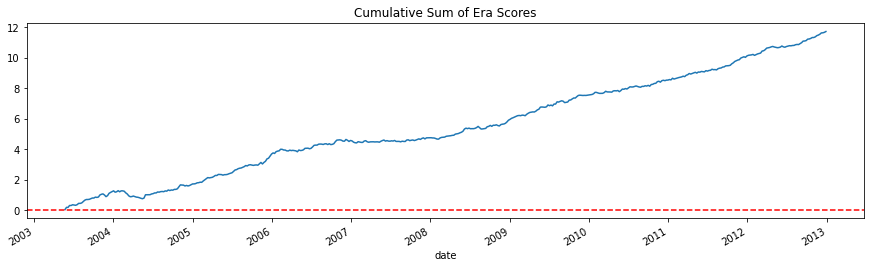

In [ ]:
#train scores, in-sample and will be significantly overfit
run_analytics(train_era_scores)

Mean Correlation: 0.0014
Median Correlation: 0.0014
Standard Deviation: 0.0309


Mean Pseudo-Sharpe: 0.0441
Median Pseudo-Sharpe: 0.0457


Hit Rate (% positive eras): 51.64%


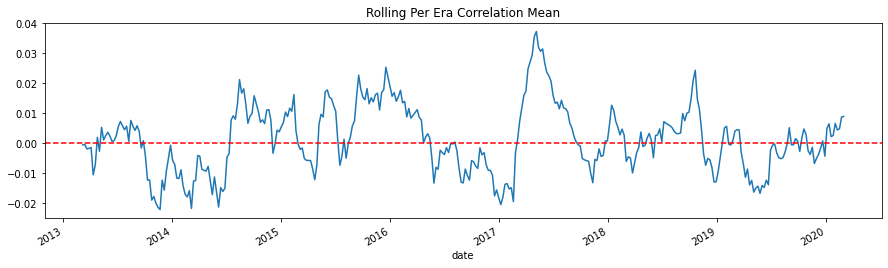

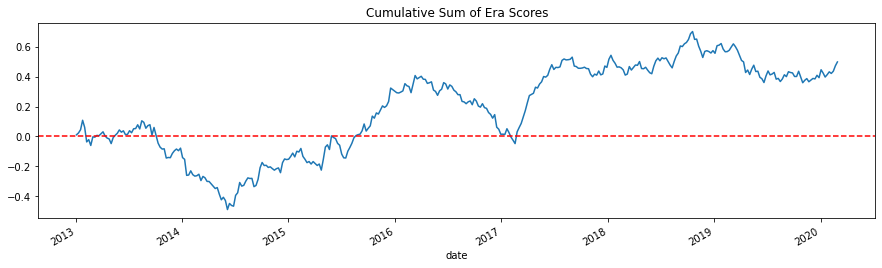

In [ ]:
#test scores, out of sample
run_analytics(test_era_scores)

## 5. Predict and submit on live data

### Choose live data

In [ ]:
# choose data as of most recent friday
last_friday = datetime.now() + relativedelta(weekday=FR(-1))
date_string = last_friday.strftime('%Y-%m-%d')

live_data = full_data.loc[date_string].copy()
live_data.dropna(subset=feature_names, inplace=True)

In [ ]:
print(f"Number of live tickers to submit: {len(live_data)}")

Number of live tickers to submit: 4439


In [ ]:
live_data.tail()

,ticker,price,RSI,RSI_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,
2020-10-09,TXT US,31.290001,71.811032,3.0,3.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,-2.0,2.0
2020-10-09,SAF FP,11.060000,65.399258,2.0,2.0,3.0,3.0,3.0,3.0,3.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-09,CAST SS,321.799988,39.090895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-09,TDG US,19.730000,71.810462,3.0,3.0,3.0,4.0,4.0,4.0,3.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2020-10-09,7012 JP,20.940001,65.301733,2.0,2.0,3.0,3.0,1.0,2.0,2.0,-1.0,1.0,0.0,0.0,2.0,2.0,-1.0,1.0,0.0,0.0


### Predict

In [ ]:
live_data[PREDICTION_NAME] = model.predict(live_data[feature_names])

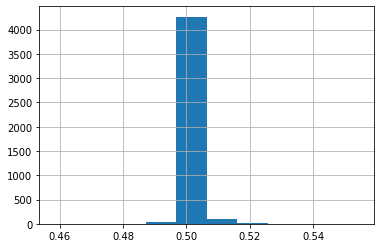

In [ ]:
# live prediction distribution
live_data[PREDICTION_NAME].hist()

In [ ]:
diagnostic_df = pd.concat([test_data, live_data])

In [ ]:
diagnostic_df.tail()

,ticker,price,RSI,RSI_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,friday_date,data_type,target,prediction
date,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-09,TXT US,31.290001,71.811032,3.0,3.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,-2.0,2.0,NaN,NaN,NaN,0.506929
2020-10-09,SAF FP,11.060000,65.399258,2.0,2.0,3.0,3.0,3.0,3.0,3.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.503254
2020-10-09,CAST SS,321.799988,39.090895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.504174
2020-10-09,TDG US,19.730000,71.810462,3.0,3.0,3.0,4.0,4.0,4.0,3.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,0.503139
2020-10-09,7012 JP,20.940001,65.301733,2.0,2.0,3.0,3.0,1.0,2.0,2.0,-1.0,1.0,0.0,0.0,2.0,2.0,-1.0,1.0,0.0,0.0,NaN,NaN,NaN,0.502368


In [ ]:
diagnostic_df['friday_date'] = diagnostic_df.friday_date.fillna(last_friday.strftime('%Y%m%d')).astype(int)
diagnostic_df['data_type'] = diagnostic_df.data_type.fillna('live')
diagnostic_df[['ticker','friday_date','data_type','prediction']].reset_index(drop=True).to_csv('example_signal_upload.csv', index=False)

### Submit live predictions via API

In [ ]:
# format predictions to match Numerai submission format
predictions = live_data[['ticker', PREDICTION_NAME]].copy()

# choose account
ACCOUNT_NAME = 'ENTER_ACCOUNT_NAME'

# write predictions to csv
live_data[['ticker', PREDICTION_NAME]].to_csv(f"{ACCOUNT_NAME} {datetime.now().strftime('%Y%m%d')}.csv", index=False)

In [ ]:
def submit_model(account_name):
    filename = f"{account_name} {datetime.now().strftime('%Y%m%d')}.csv"
    model_id = napi.get_models()[f'{account_name}']
    submission = napi.upload_predictions(filename, model_id=model_id)
    print(submission)

In [ ]:
submit_model(ACCOUNT_NAME)

### Stake on submission
Confident in your live signals? Visit https://signals.numer.ai/models to place and manage stakes

## Suggestions for improvement
This example script isn't perfect, but it's a great framework to build off of.

* Try different features or other technical indicators derived from price data. RSI is used as an example here, but there are many others like it (MACD, EWMA, etc.). We used a short-term window of time. Try to use longer time windows and intervals.

* Additional feature engineering may go a long way. We took RSI quintiles and their lags and differences, but the number of possible combinations is much larger. See https://github.com/blue-yonder/tsfresh/blob/main/tsfresh/feature_extraction/feature_calculators.py for other ideas (h/t objectscience). Think about how to turn time series price data into a cross-sectional machine learning problem.

* Neutralize your features with respect to time. Taking relative rankings within each era and differencing can help like we did here, but more attention to stationarity will likely improve performance.

* Find non-price data to layer into your feature set. Pricing data and its derivatives will be the most common and therefore likely the most correlated with other submissions.

* Neutralize your features to country, sector, industry, or other fields/metadata that may be specific to a group of securities.

* Try other types of algorithms/models and tune your hyper-parameters with time-series cross-validation. https://forum.numer.ai/t/era-wise-time-series-cross-validation/791

* Make your own targets. It's possible your alpha from other timeframes and strategies will do well on Numerai Signals. Submit and check your diagnostics.

* Lean on the community. This script already has many suggestions and implementations from other community members baked in. Share your thoughts at https://community.numer.ai/channel/signals

# About

Last updated: 2020-10-16

Created by: Jason Rosenfeld

- Numerai: [jrai](https://numer.ai/jrai)

- Twitter: [@jrosenfeld13](https://twitter.com/jrosenfeld13)